<a href="https://colab.research.google.com/github/jasondrebber/GEOL558/blob/main/SupervisedClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Alaskan Rocks using XRF data
## Jason Drebber
####1/26/2025

For this project I selected geochemical data from the USGS which records XRF data and rock classifications for over 3,000 rocks in northern Alaska. I intend to use the XRF data to classify the rock type using the XRF data. I hope that although this is not directly related to my research, I do work with a significant number of igneous rocks for geochemical analysis and intend to do XRF for my reserach, so I am hoping to gain some familiarity with common XRF signature for different rock types that I can use to carry over to my work. I selected northern Alaska simply because it is intersting to me and I love learning about Alaska. All data used in this project is publicaly avaialble from the USGS National Geochemical Database at https://mrdata.usgs.gov/ngdb/rock/geo-inventory.php

### Imports

In [47]:
# Import packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


import warnings as wr
wr.filterwarnings("ignore")

### Load Data

This data is downloaded from the USGS National Geochemical Database (ngdb) for rock data. I specifically selected Alaska in the data viewer and then reduced the selecction further to download only the North-Slope rock data. This data therefore represents rock classifications from the northernmost part of Alaska including the rock type (label) and the XRF data (feature matrix) that I can use to predict the rock type using different classification algorithms. The raw data contains many other columns that will ahve to be removed in pre-processing.

In [48]:
# Add the raw data
url1 =  'https://raw.githubusercontent.com/jasondrebber/GEOL558/fb0bd8e8f83a6058dfc07740c182f7c37326c59b/tblRockGeoData.txt'
raw_rock = pd.read_csv(url1)
raw_rock.head()

,lab_id,job_id,submitter,date_sub,field_id,state,country,datum,spheroid,latitude,...,mineralztn,alteration,struct_src,dep_envirn,source_rk,metamrphsm,facies_grd,prep,mesh_size,Unnamed: 31
0,ACF401,HM692,"Brew, David A.",19670918,67ABD006A,AK,NaN,NaN,NaN,58.52647,...,NaN,Fe alteration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ACF451,HM692,"Brew, David A.",19670918,67ABD081D,AK,NaN,NaN,NaN,58.57964,...,mineralization present,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ACF452,HM692,"Brew, David A.",19670918,67ABD082B,AK,NaN,NaN,NaN,58.58703,...,NaN,Fe alteration,pluton,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ACF453,HM692,"Brew, David A.",19670918,67ABD090B,AK,NaN,NaN,NaN,58.60992,...,NaN,Fe alteration,pluton,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ACF454,HM692,"Brew, David A.",19670918,67ABD106,AK,NaN,NaN,NaN,58.65139,...,vein,Fe alteration,dike/sill,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
url2 = 'https://raw.githubusercontent.com/jasondrebber/GEOL558/fb0bd8e8f83a6058dfc07740c182f7c37326c59b/xtbMajorChem.txt'
raw_chem = pd.read_csv(url2)
raw_chem.head()

,lab_id,sio2_xrf,sio2_xrfq,sio2_grv,sio2_grvq,sio2_aes,sio2_aesq,sio2_aa,sio2_aaq,sio2_clr,...,cl_mscq,cl_unk,cl_unkq,f_elctrd,f_elctrdq,f_msc,f_mscq,f_unk,f_unkq,Unnamed: 191
0,C105286,54.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,C105287,79.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,C105288,82.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,C105289,62.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,C105290,82.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Pre-processing

In the code below I will perform initial pre-processing on the data. I start with saving only the columns of data that I want to work with. This was determined through detailed evaluation of the raw data downloaded from the USGS. Next I combined the two raw data files based on a common attribute (lab_id) then checked for NaN values and removed them. I did not lose any significant amount of data form this because most of the rows of data which did not have one of the XRF data types did not have all of them making those samples fairly useless for classification. This is my explanation for not imputing the data into those cells. Finally here I perform some basic data analysis on the data to analyze possible trends in the data through both numeric statistical and graphical means.

In [50]:
# Save only necessary columns from the rocks data frame
rock = raw_rock[['lab_id', 'xndryclass', 'spec_name']]
rock.head()

,lab_id,xndryclass,spec_name
0,ACF401,metamorphic,gneiss
1,ACF451,igneous,unspecified
2,ACF452,igneous,granite
3,ACF453,igneous,mafic
4,ACF454,igneous,unspecified


In [51]:
# Save only necessary columns from the chem data frame
chem = raw_chem[['lab_id', 'sio2_xrf', 'al2o3_xrf', 'feto3_xrf', 'mgo_xrf', 'cao_xrf', 'na2o_xrf', 'k2o_xrf', 'tio2_xrf', 'p2o5_xrf', 'mno_xrf']]
chem.head()

,lab_id,sio2_xrf,al2o3_xrf,feto3_xrf,mgo_xrf,cao_xrf,na2o_xrf,k2o_xrf,tio2_xrf,p2o5_xrf,mno_xrf
0,C105286,54.1,17.70,10.30,3.63,0.62,2.02,4.52,0.68,0.25,0.04
1,C105287,79.6,6.51,2.88,0.73,0.54,0.15,1.78,0.29,0.47,0.01
2,C105288,82.1,7.78,2.10,1.50,0.03,0.99,1.69,0.27,0.09,0.04
3,C105289,62.1,12.70,5.74,3.65,4.31,4.23,0.26,0.70,0.27,0.06
4,C105290,82.8,7.99,1.96,0.90,0.34,0.98,1.30,0.35,0.18,0.02


In [52]:
# Combine the data based on the lab id feature
rock = pd.merge(rock, chem, on='lab_id')
rock.drop(columns=['lab_id'], inplace=True)
rock.head()

,xndryclass,spec_name,sio2_xrf,al2o3_xrf,feto3_xrf,mgo_xrf,cao_xrf,na2o_xrf,k2o_xrf,tio2_xrf,p2o5_xrf,mno_xrf
0,metamorphic,meta-argillite,54.1,17.70,10.30,3.63,0.62,2.02,4.52,0.68,0.25,0.04
1,metamorphic,phyllite,79.6,6.51,2.88,0.73,0.54,0.15,1.78,0.29,0.47,0.01
2,metamorphic,meta-argillite,82.1,7.78,2.10,1.50,0.03,0.99,1.69,0.27,0.09,0.04
3,metamorphic,meta-argillite,62.1,12.70,5.74,3.65,4.31,4.23,0.26,0.70,0.27,0.06
4,metamorphic,meta-argillite,82.8,7.99,1.96,0.90,0.34,0.98,1.30,0.35,0.18,0.02


In [53]:
# Look at basic features of the data
print(rock.shape)
rock.info()

(4651, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4651 entries, 0 to 4650
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   xndryclass  4651 non-null   object 
 1   spec_name   4499 non-null   object 
 2   sio2_xrf    3678 non-null   float64
 3   al2o3_xrf   3678 non-null   float64
 4   feto3_xrf   3678 non-null   float64
 5   mgo_xrf     3678 non-null   float64
 6   cao_xrf     3678 non-null   float64
 7   na2o_xrf    3678 non-null   float64
 8   k2o_xrf     3678 non-null   float64
 9   tio2_xrf    3678 non-null   float64
 10  p2o5_xrf    3673 non-null   float64
 11  mno_xrf     3677 non-null   float64
dtypes: float64(10), object(2)
memory usage: 436.2+ KB


In [54]:
# Check for NaNs in each column
rock.isna().sum()

,0
xndryclass,0
spec_name,152
sio2_xrf,973
al2o3_xrf,973
feto3_xrf,973
mgo_xrf,973
cao_xrf,973
na2o_xrf,973
k2o_xrf,973
tio2_xrf,973


In [55]:
# Drop the NaNs from each column
rock = rock.dropna()
print(rock.isna().sum())
print(rock.shape)

xndryclass    0
spec_name     0
sio2_xrf      0
al2o3_xrf     0
feto3_xrf     0
mgo_xrf       0
cao_xrf       0
na2o_xrf      0
k2o_xrf       0
tio2_xrf      0
p2o5_xrf      0
mno_xrf       0
dtype: int64
(3614, 12)


In [56]:
# Look at the sumamry statistics of the feature data
rock.describe()

,sio2_xrf,al2o3_xrf,feto3_xrf,mgo_xrf,cao_xrf,na2o_xrf,k2o_xrf,tio2_xrf,p2o5_xrf,mno_xrf
count,3614.000000,3614.000000,3614.000000,3614.000000,3614.000000,3614.000000,3614.000000,3614.000000,3614.000000,3614.000000
mean,57.673129,14.592559,7.221242,3.933924,6.254962,3.182460,1.951547,0.804037,0.272894,0.155557
std,13.496444,4.383189,4.695447,4.675774,5.395458,1.624798,1.630993,0.651536,0.827463,0.287212
min,0.100000,0.100000,0.040000,0.020000,0.003000,0.150000,0.010000,0.020000,0.005000,0.007000
25%,48.300000,13.500000,3.510000,1.010000,2.460000,2.320000,0.720000,0.340000,0.100000,0.070000
50%,57.700000,15.700000,6.700000,2.780000,5.680000,3.430000,1.640000,0.660000,0.200000,0.130000
75%,67.000000,17.300000,10.400000,5.517500,8.617500,4.040000,2.680000,1.070000,0.310000,0.180000
max,98.700000,28.500000,65.600000,46.800000,54.400000,10.100000,11.100000,6.830000,32.100000,8.240000


In [57]:
# Look at counts of the number of each target
rock['xndryclass'].value_counts()

,count
xndryclass,
igneous,2383
metamorphic,1105
sedimentary,126


In [58]:
# Look at counts of the specific rock types
rock['spec_name'].value_counts()

,count
spec_name,
granodiorite,460
basalt,306
tonalite,287
greenstone,214
quartz diorite,178
...,...
olivine norite,1
metaclaystone,1
diabase porphyry,1


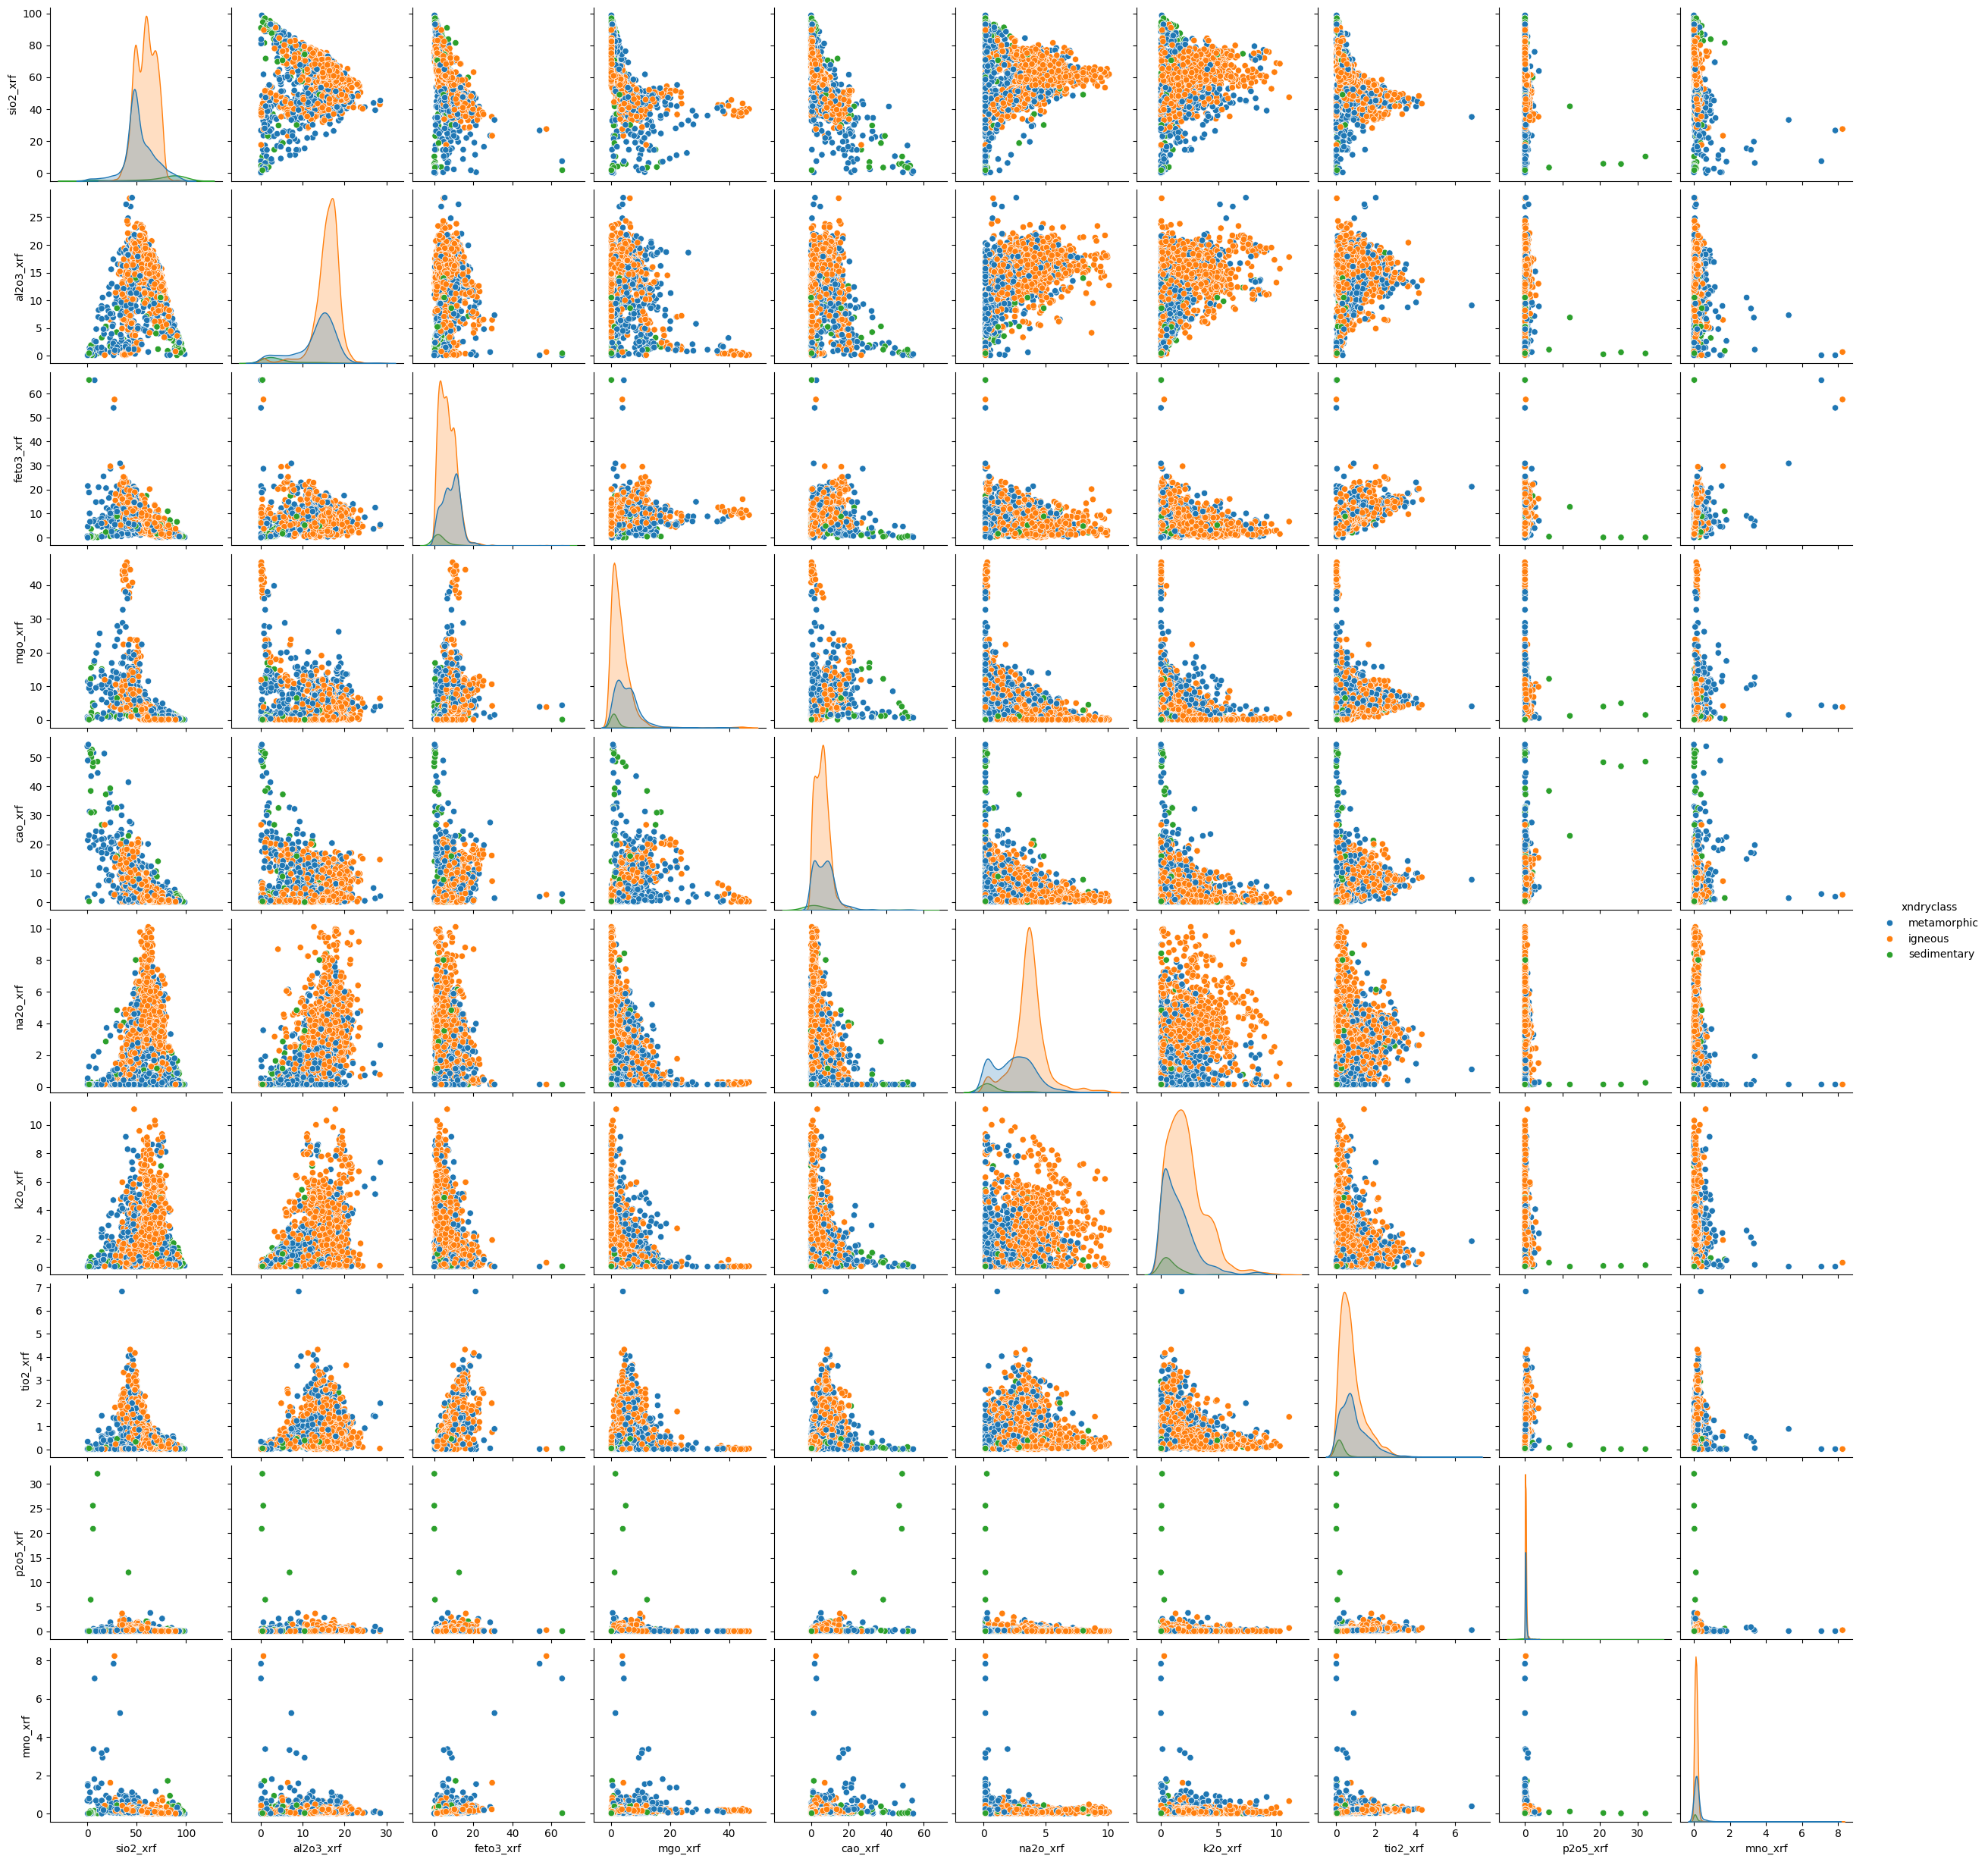

In [59]:
# Plot a seaborn pair plot of the feature matrix
sns.pairplot(rock, hue='xndryclass')

<Axes: >

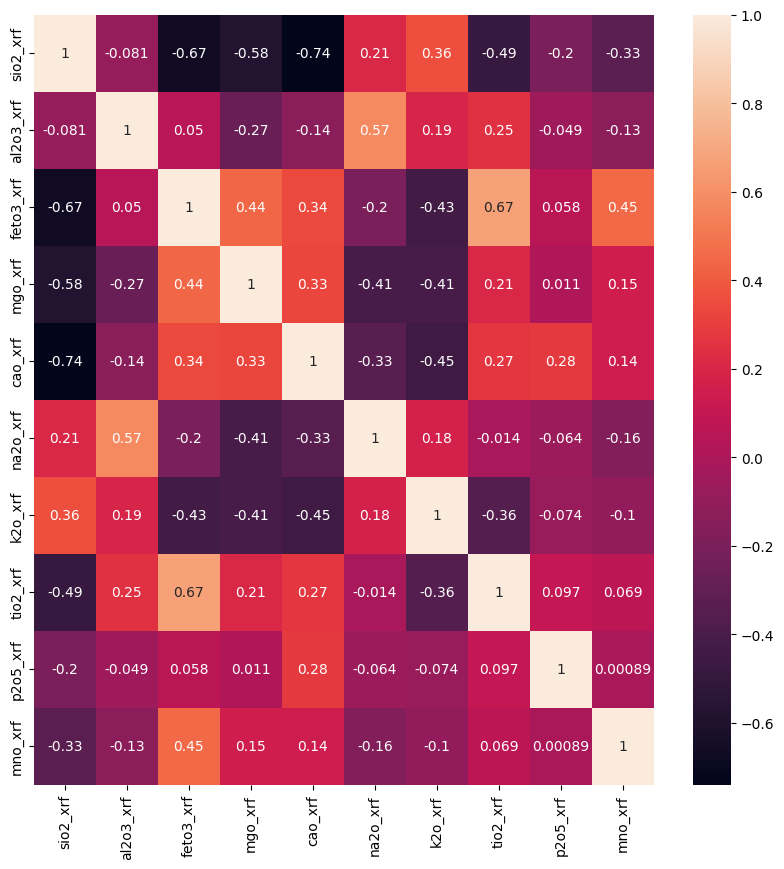

In [60]:
# Plot a correlation heatmap of the feature data
plt.figure(figsize=(10,10))
sns.heatmap(rock.select_dtypes('number').corr(), annot=True)

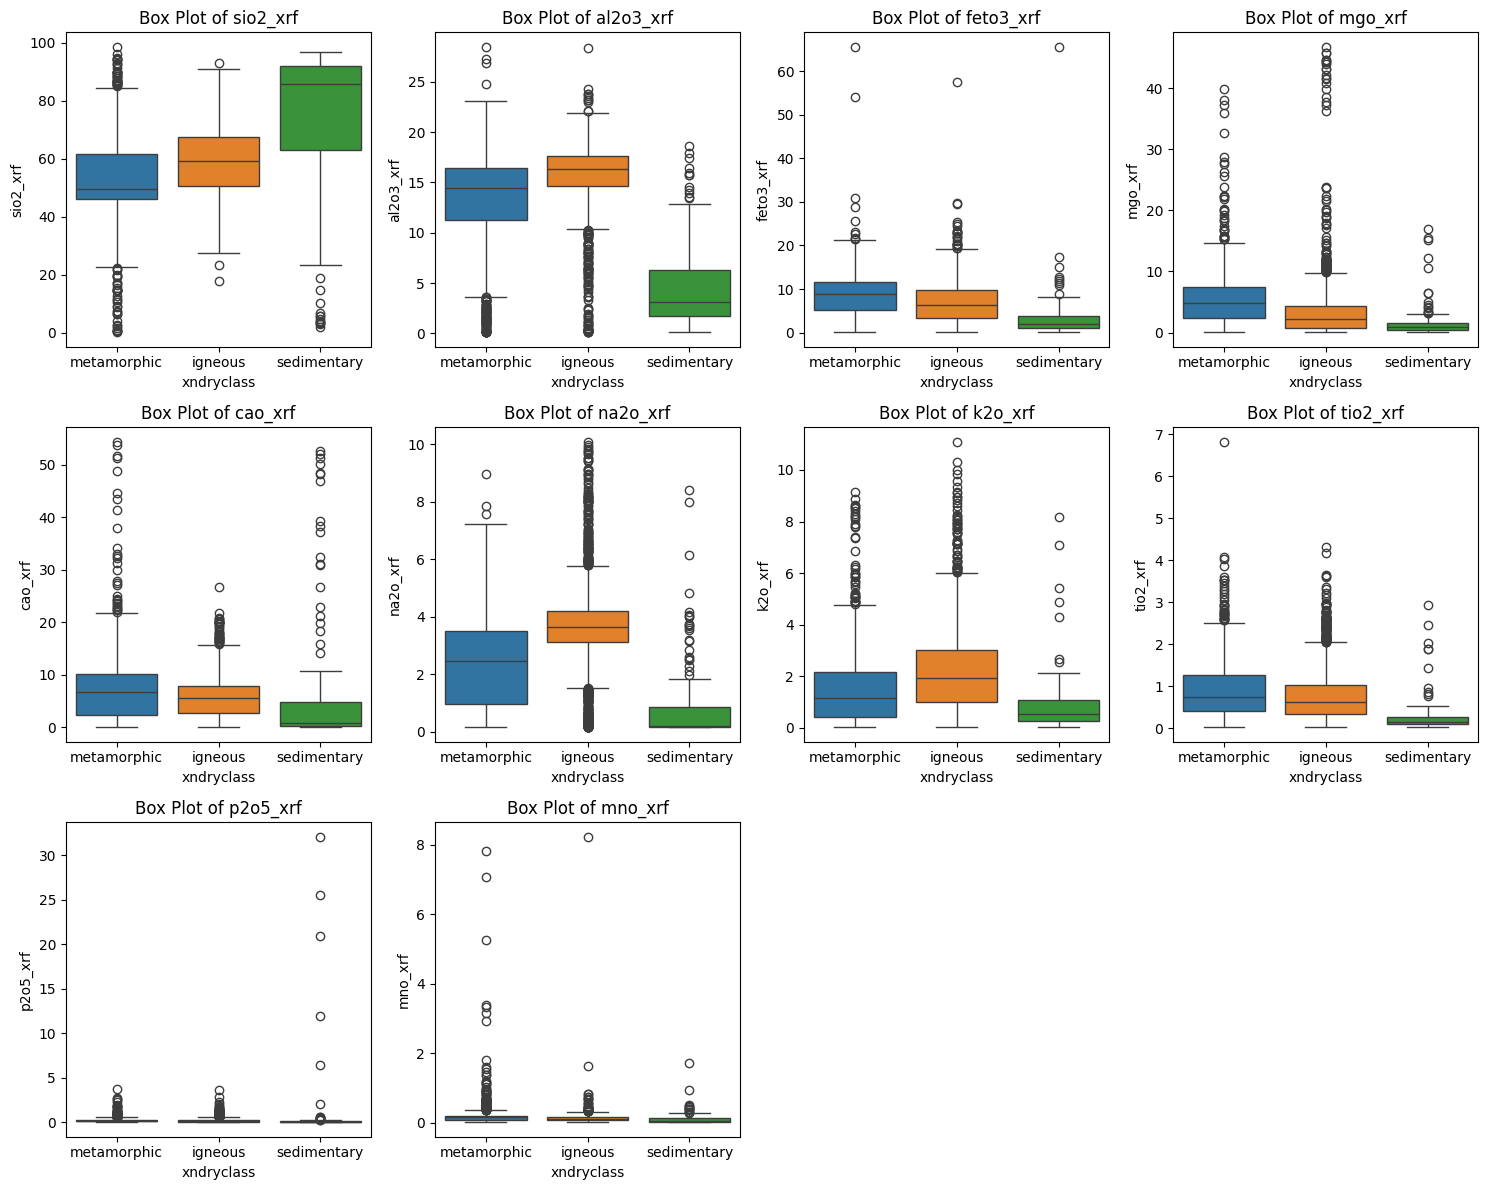

In [61]:
# Plot box plots for all of the features classed by the target to see how the features relate
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 12))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through the features (excluding 'xndryclass' and 'spec_name')
for i, feature in enumerate(rock.columns.drop(['xndryclass', 'spec_name'])):
  # Create a box plot for the current feature grouped by 'xndryclass'
  sns.boxplot(x='xndryclass', y=feature, data=rock, ax=axes[i], hue='xndryclass')
  axes[i].set_title(f'Box Plot of {feature}')

# Remove any unused subplots
for i in range(len(rock.columns.drop(['xndryclass', 'spec_name'])), len(axes)):
  fig.delaxes(axes[i])

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

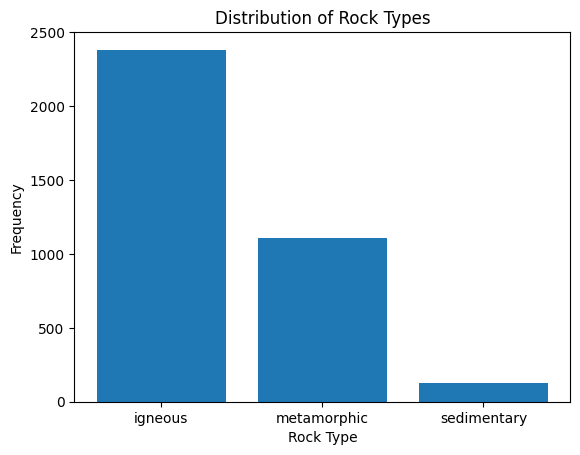

In [62]:
# Plot a bar chart of the different class features to see how many there are
plt.bar(x=rock['xndryclass'].value_counts().index, height=rock['xndryclass'].value_counts().values)
plt.xlabel("Rock Type")
plt.ylabel("Frequency")
plt.title("Distribution of Rock Types")
plt.show()

###### Summary of EDA

The above EDA shows some interesting and relevant trends which I expect will carry over into the classification. First of all I will point out that the data is somewhat unbalanced. There is a large amount of igneous rock data, somewhat less metamorphic rock data and only very little sedimentary data. I am curious how this will impact my classifier. If it appears to be an issue I will use a balancing tool to create samples of the data to make a balanced dataset. The first thing I notice in the numeric EDA is that on average SiO2 accounts for the highesst proportion of each rock type at 57%. This is followed by Al2O3 at 14.7%. Both of these align with my understanding of common rock composition so it is not very surprising. The other elements make up the rest and account for less than 10% each. Manganese, Phosphorus and Titanium all account for less than 1% on average however play more important rols in certain cases. For example Phosphorus which accounts for very little of most rocks can be up to 32% of some sediemntary rocks meaning that it may be more important for identifying and classifying sedimentary rocks when it is present in any significant porportion. Beyond the trend in phosphorus there is also an intersting relationship between SiO2 and Al2O3 in the scatter plot where SiO2 appears to be somewhat normally distributed around the mean value while Al2O3 varies more uniformly. This is somewhat odd of a relatiopnship for a scatter plot. The correlation heat map suggests that these two features are highly inversely related. And analysis of the box plots shows that sedimentary rocks on average have higher silica and lower alumnium content than either igneous or metamorphic rocks suggesting that these two are also indicative of sedimentary rocks in many cases. Igneous rocks in this area appear to have the highest sodium and potassium content suggesting that they are mostly alkaline igneous rocks and likely contain significant feldspars. I think that these features will be important for identifying the igenous rocks in this dataset. Other intersting trends is that Calcium, iron and magnesium are all highly negatively correlated with silica. Titanium and Iron are positiely correlated as are Aluminum and Calcium. It is apparent that many of the mafic elements vary inversely with the felsic elements. I think that overall this data is behaving exactly as I would expect it to.

This is not big data, this is only a few thousand samples of about 8 features so although it is a lot of data and would be hard to process by hand, it is not big data by most standards. I think if I included all of the rock classification data for the US then it would be big data. I actually tried to get the data for the entire US but it was too large to store in github so instead I just went with a specific area.